In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import os
import sys

import tarfile
from six.moves import cPickle as pickle
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

In [10]:
!pip install tqdm



     |████████████████████████████████| 61kB 2.4MB/s eta 0:00:011
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:

import tqdm

In [12]:
import cv2

In [19]:
apple_dir_names = ['data/dml_dataset/Apple/Total Number of Apples/']
guava_dir_names = ['data/dml_dataset/Guava/guava total final/']
kiwi_dir_names = ['data/dml_dataset/Kiwi/Total Number of Kiwi fruit/']

def get_filenames_from_directory_list(directory_list):
    paths = []
    for directory in directory_list:
        paths.extend([directory + path for path in os.listdir(directory)])
    return paths

apple_paths = get_filenames_from_directory_list(apple_dir_names)
guava_paths = get_filenames_from_directory_list(guava_dir_names)
kiwi_paths = get_filenames_from_directory_list(kiwi_dir_names)

In [14]:
from matplotlib import pyplot as plt
import cv2

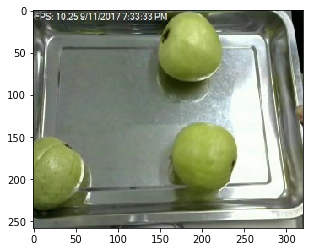

In [24]:
img = cv2.imread(guava_paths[123])
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [29]:
img.shape

(258, 320, 3)

In [30]:
fruits_to_id = {'apple': 0, 'guava': 1, 'kiwi': 2}
id_to_ftuits = {0: 'apple', 1: 'guava', 2: 'kiwi'}

In [3]:
min(len(apple_paths), len(guava_paths), len(kiwi_paths))

4008

In [3]:
apple_paths[0]

'data/dml_dataset/Apple/Total Number of Apples/Apple 03577.png'

In [15]:
img = cv2.imread(apple_paths[4001])
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

IndexError: list index out of range

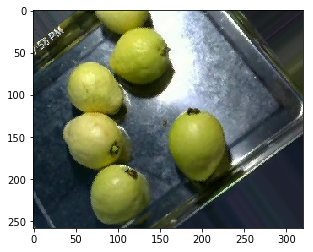

In [21]:
img = cv2.imread(guava_paths[4001])
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

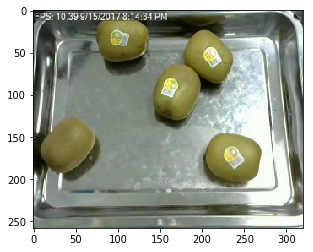

In [22]:
img = cv2.imread(kiwi_paths[4001])
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)

In [7]:
# take 4000 images
apple_paths = apple_paths[:4000]
guava_paths = guava_paths[:4000]
kiwi_paths = kiwi_paths[:4000]

In [8]:
import random
import numpy as np

In [9]:
random.shuffle(apple_paths)
random.shuffle(guava_paths)
random.shuffle(kiwi_paths)

In [10]:
# prepare and shuffle the data

train_paths = []
train_y = []
valid_paths = []
valid_y = []
test_paths = []
test_y = []

train_paths.extend(apple_paths[:3200])
train_y.extend([0]*3200)
train_paths.extend(guava_paths[:3200])
train_y.extend([1]*3200)
train_paths.extend(kiwi_paths[:3200])
train_y.extend([2]*3200)

valid_paths.extend(apple_paths[3200:3600])
valid_y.extend([0]*400)
valid_paths.extend(guava_paths[3200:3600])
valid_y.extend([1]*400)
valid_paths.extend(kiwi_paths[3200:3600])
valid_y.extend([2]*400)

test_paths.extend(apple_paths[3600:4000])
test_y.extend([0]*400)
test_paths.extend(guava_paths[3600:4000])
test_y.extend([1]*400)
test_paths.extend(kiwi_paths[3600:4000])
test_y.extend([2]*400)


train_paths = np.array(train_paths)
valid_paths = np.array(valid_paths)
test_paths = np.array(test_paths)
train_y = np.array(train_y)
valid_y = np.array(valid_y)
test_y = np.array(test_y)

train_idx = np.random.permutation(len(train_paths))
valid_idx = np.random.permutation(len(valid_paths))
test_idx = np.random.permutation(len(test_paths))


train_paths = train_paths[train_idx]
train_y = train_y[train_idx]

valid_paths = valid_paths[valid_idx]
valid_y = valid_y[valid_idx]

test_paths = test_paths[test_idx]
test_y = test_y[test_idx]


In [11]:
import os  # used for directory operations
import numpy as np
import tensorflow as tf
from PIL import Image  #

In [12]:
recordPath = "tfrecord/"

In [24]:
from matplotlib.pyplot import imshow



img = Image.open(apple_paths[0],'r')
img_resize = img.resize((150,150))
#print(img_resize.shape)
print(np.asarray(img_resize).shape)
#imshow(np.asarray(img))

(150, 150, 3)


In [26]:
def prepare_tf_record(paths, labels, record_file_path):
    writer = tf.io.TFRecordWriter(record_file_path)
    for idx, path in tqdm.tqdm(enumerate(paths)):
        img = Image.open(path, "r")
        img_resize = img.resize((150,150))
        img_raw = np.array(img_resize).tobytes()
        example = tf.train.Example(features=tf.train.Features(feature={
                "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw])),
                "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[labels[idx]]))}))
        writer.write(example.SerializeToString())
    writer.close()

In [32]:
prepare_tf_record(train_paths, train_y, recordPath + '/train/train.tfrecords')
prepare_tf_record(valid_paths, valid_y, recordPath + '/validation/validation.tfrecords')
prepare_tf_record(test_paths, test_y, recordPath + '/eval/eval.tfrecords')

9600it [00:54, 176.70it/s]
1200it [00:05, 216.13it/s]
1200it [00:05, 223.26it/s]


In [28]:
bucket_name = 'cloud-csce678-dml-bucket'

In [33]:
!aws s3 sync tfrecord/ s3://{bucket_name}/fruit_dataset/

upload: tfrecord/eval/eval.tfrecords to s3://cloud-csce678-dml-bucket/fruit_dataset/eval/eval.tfrecords
upload: tfrecord/validation/validation.tfrecords to s3://cloud-csce678-dml-bucket/fruit_dataset/validation/validation.tfrecords
upload: tfrecord/train/train.tfrecords to s3://cloud-csce678-dml-bucket/fruit_dataset/train/train.tfrecords


In [30]:
def from_categorical(lst):
    """
    Inverse of to_categorical
    Example: [[0,0,0,1,0], [1,0,0,0,0]] => [3,0]
    """
    
    lst = lst.tolist()
    lst2 = []
    for x in lst:
        lst2.append(x.index(max(x)))
    return lst2

In [31]:
x = from_categorical(train_y)

AttributeError: 'int' object has no attribute 'index'

In [34]:
!S3_REGION=us-east-2 tensorboard --logdir s3://{bucket_name}/tensorboard_logs/


TensorBoard 1.15.0 at http://ip-172-16-59-129:6007/ (Press CTRL+C to quit)
^C
